# Image Classification Using CNN
By : Mohamed Mamdouh Elaghory

________

we'll build a CNN using Keras to use it classifying thousands of pictures in six different categories

### **About Dataset**

#### **Context**
This is image data of Natural Scenes around the world.

#### **Content**
This Data contains around 25k images of size 150x150 distributed under 6 categories.

{'buildings' -> 0,

'forest'    --> 1,

'glacier'   --> 2,

'mountain'  --> 3,

'sea'       --> 4,

'street'    --> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
_____

Data link : https://www.kaggle.com/puneet6060/intel-image-classification

### Test Acc : **`77.5 %`**
### Test Acc after Augmentation : **`84.5 %`**


first to import libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import os
import glob as gb                      # is a library to [open folders]
import cv2                             # is a library to [resize image]
from skimage.color import rgb2gray     # to convert image to grayscale

from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [2]:
# Install the Kaggle library
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
from google.colab import files
files.upload()                     # upload [kaggle.json]

In [4]:
# Make a folder named “.kaggle”
! mkdir ~/.kaggle

In [5]:
# Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

In [6]:
# Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Mount Drive:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [9]:
! kaggle datasets download -d puneet6060/intel-image-classification

 98% 338M/346M [00:01<00:00, 245MB/s]
100% 346M/346M [00:01<00:00, 217MB/s]


In [10]:
# Unzip the Dataset zip file:
! unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [11]:
trainpath= 'seg_train/'
testpath = 'seg_test/'
predpath = 'seg_pred/'

# Open Folders

now let's first check the Train folder to have a look to its content

In [ ]:
for folder in  os.listdir(trainpath + 'seg_train') : 
    files = gb.glob(pathname= str( trainpath +'seg_train/' + folder + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {folder}')

For training data , found 2274 in folder sea
For training data , found 2512 in folder mountain
For training data , found 2191 in folder buildings
For training data , found 2404 in folder glacier
For training data , found 2382 in folder street
For training data , found 2271 in folder forest


ok , how about the test folder

In [ ]:
for folder in  os.listdir(testpath +'seg_test') : 
    files = gb.glob(pathname= str( testpath +'seg_test/' + folder + '/*.jpg'))
    print(f'For testing data , found {len(files)} in folder {folder}')

For testing data , found 510 in folder sea
For testing data , found 525 in folder mountain
For testing data , found 437 in folder buildings
For testing data , found 553 in folder glacier
For testing data , found 501 in folder street
For testing data , found 474 in folder forest


_____
now for prediction folder

In [ ]:
files = gb.glob(pathname= str(predpath +'seg_pred/*.jpg'))
print(f'For Prediction data , found {len(files)}')

For Prediction data , found 7301


_____

# Checking Images

now we need to heck the images sizes , to know how they looks like

since we have 6 categories , we first need to create a dictionary with their names & indices , also create a function to get the code back

In [12]:
code = {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x    

### to display the images sizes in ` train folder`

In [ ]:
size = []
for folder in  os.listdir(trainpath +'seg_train') : 
    files = gb.glob(pathname= str( trainpath +'seg_train/' + folder + '/*.jpg'))
    for file in files: 
        original_img = plt.imread(file)
        img= rgb2gray(original_img)           # convert it to grayscale.
        size.append(img.shape)
pd.Series(size).value_counts()                # almost all of images are [150,150]

(150, 150)    13986
(113, 150)        7
(135, 150)        3
(111, 150)        3
(144, 150)        2
(108, 150)        2
(123, 150)        2
(142, 150)        2
(143, 150)        2
(136, 150)        2
(146, 150)        2
(134, 150)        2
(149, 150)        1
(102, 150)        1
(110, 150)        1
(133, 150)        1
(120, 150)        1
(119, 150)        1
(97, 150)         1
(76, 150)         1
(81, 150)         1
(105, 150)        1
(124, 150)        1
(145, 150)        1
(140, 150)        1
(100, 150)        1
(147, 150)        1
(103, 150)        1
(131, 150)        1
(141, 150)        1
(115, 150)        1
dtype: int64

_____
### to display the images sizes in ` test folder`

In [ ]:
size = []
for folder in  os.listdir(testpath +'seg_test') : 
    files = gb.glob(pathname= str( testpath +'seg_test/' + folder + '/*.jpg'))
    for file in files: 
        original_img = plt.imread(file)
        img= rgb2gray(original_img)           # convert it to grayscale.
        size.append(img.shape)
pd.Series(size).value_counts()                # almost all of images are [150,150,3]

(150, 150)    2993
(131, 150)       1
(81, 150)        1
(76, 150)        1
(149, 150)       1
(72, 150)        1
(110, 150)       1
(141, 150)       1
dtype: int64

_____
### to display the images sizes in ` predict folder`

In [ ]:
size = []
files = gb.glob(pathname= str(predpath +'seg_pred/*.jpg'))
for file in files: 
    original_img = plt.imread(file)
    img= rgb2gray(original_img)           # convert it to grayscale.
    size.append(img.shape)
pd.Series(size).value_counts()            # almost all of images are [150,150,3]

(150, 150)    7288
(108, 150)       1
(133, 150)       1
(143, 150)       1
(131, 150)       1
(374, 500)       1
(129, 150)       1
(149, 150)       1
(100, 150)       1
(139, 150)       1
(126, 150)       1
(144, 150)       1
(112, 150)       1
(124, 150)       1
dtype: int64

ok , since almost all of pictures are 150,150,3 , we can feel comfort in using all pictures in our model , after resizing it in a specific amount

# Reading Images

- now it's time to read all images & convert it into arrays

- first we'll create a variable [s] , which refer to size , so we can change it easily. 

- let's use now size = 100 , so it will be suitable amount to contain accuracy without losing so much time in training

### 1. Read Image from [ train folder ]

In [13]:
s = 100

now to read all pictues in six categories in training folder, ans use OpenCV to resize it , and not to forget to assign the y value , from the predefined function 

In [14]:
X_train = []
y_train = []
for folder in  os.listdir(trainpath +'seg_train') : 
    files = gb.glob(pathname= str( trainpath +'seg_train//' + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file, 0)                  # 0   means convert image to grayscale.
        image_array = cv2.resize(image , (s,s))      # will resize image to 100*100 dimension & return the array per image.
        X_train.append(list(image_array))
        y_train.append(code[folder])

great , now how many items in X_train 

In [15]:
print(f'X_train is:  {len(X_train)} images')
print(f'y_train is:  {len(y_train)} label for each image')

X_train is:  14034 images
y_train is:  14034 label for each image


also we have have a look to random pictures in X_train , and to adjust their title using the y value

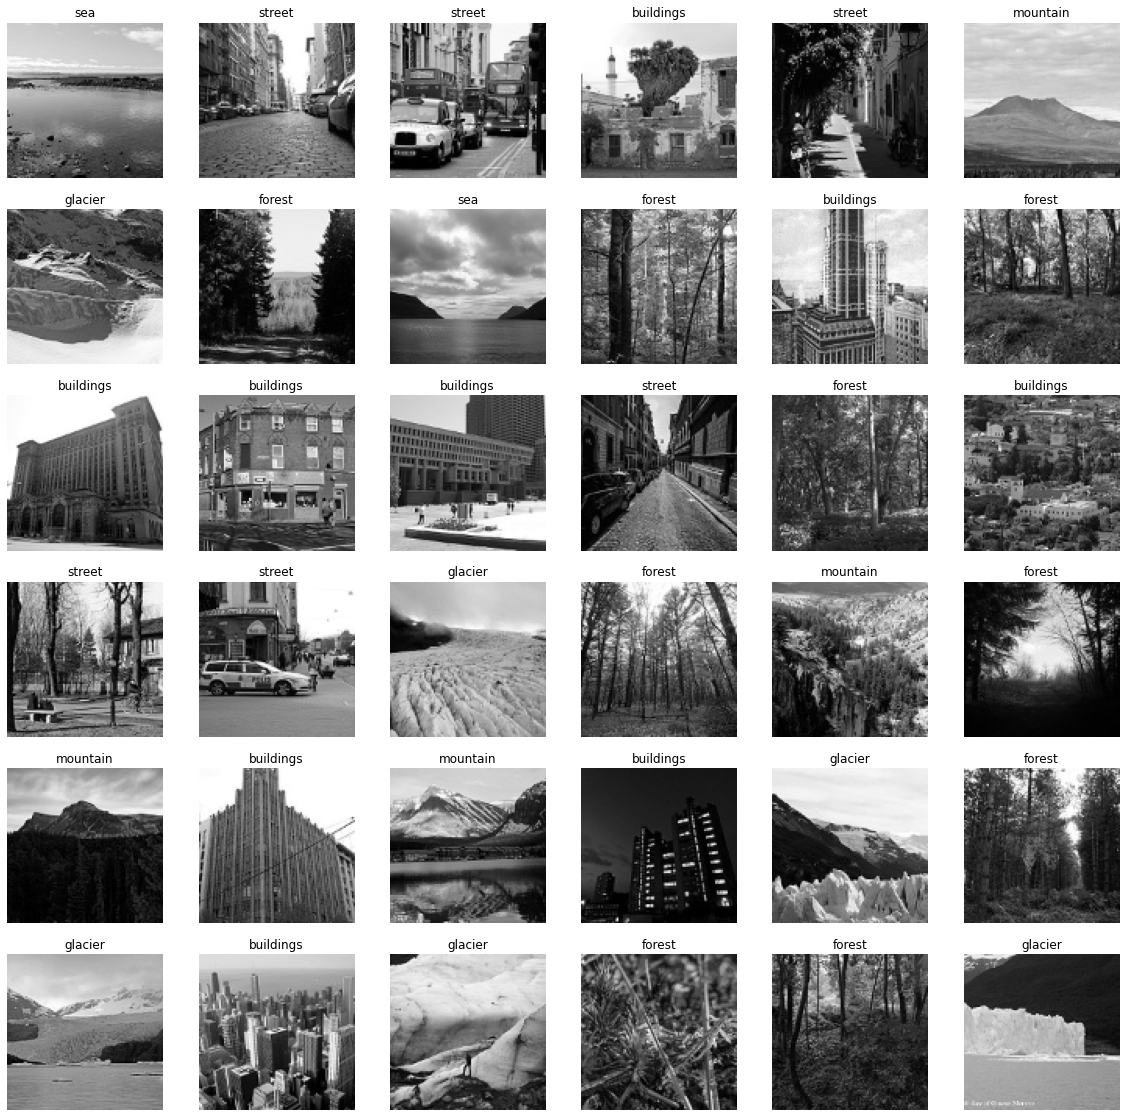

In [16]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train),36))) :       # print any 36 images from X_train images.
    plt.subplot(6,6,n+1)
    plt.imshow(X_train[i], cmap= 'gray')   
    plt.axis('off')
    plt.title(getcode(y_train[i]))

____
### 2. Read Image from [ test folder ]

In [17]:
X_test = []
y_test = []
for folder in  os.listdir(testpath +'seg_test') : 
    files = gb.glob(pathname= str(testpath + 'seg_test//' + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file, 0)                   # 0   means convert image to grayscale.
        image_array = cv2.resize(image , (s,s))       # will resize image to 100*100 dimension & return the array per image.
        X_test.append(list(image_array))
        y_test.append(code[folder])
        

In [18]:
print(f'X_test is:  {len(X_test)} images')
print(f'y_test is:  {len(y_test)} label for each image')

X_test is:  3000 images
y_test is:  3000 label for each image


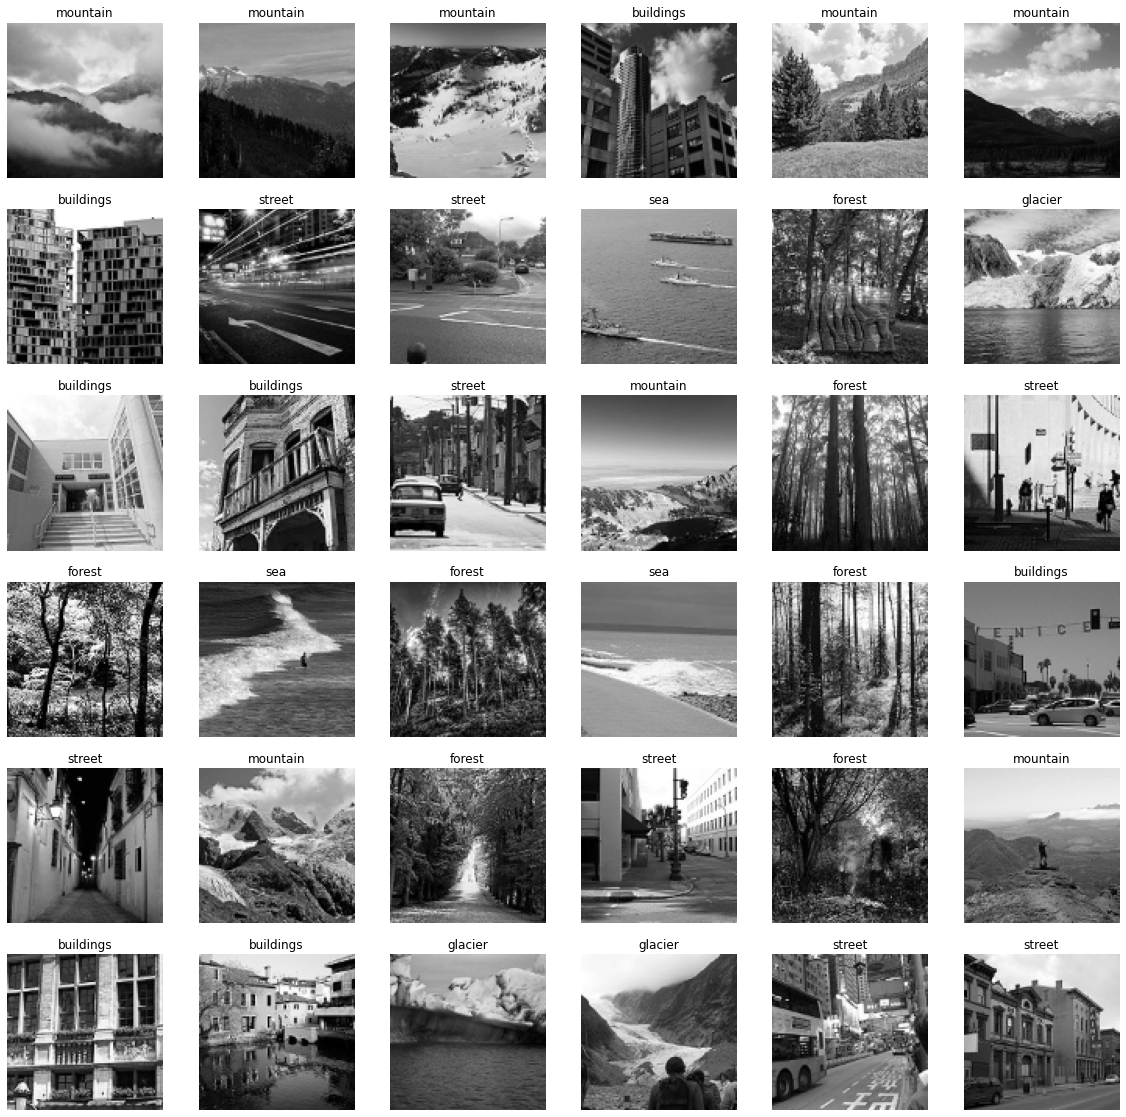

In [19]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_test),36))) :         # print any 36 images from X_test images.
    plt.subplot(6,6,n+1)
    plt.imshow(X_test[i], cmap= 'gray')    
    plt.axis('off')
    plt.title(getcode(y_test[i]))

____
### 3. Read Image from [ predict folder ] , without having label of course

In [20]:
X_pred = []
files = gb.glob(pathname= str(predpath + 'seg_pred/*.jpg'))
for file in files: 
    image = cv2.imread(file, 0)                     # 0   means convert image to grayscale.
    image_array = cv2.resize(image , (s,s))         # will resize image to 100*100 dimension & return the array per image.
    X_pred.append(list(image_array))       

In [21]:
print(f'X_pred is:  {len(X_pred)} images')

X_pred is:  7301 images


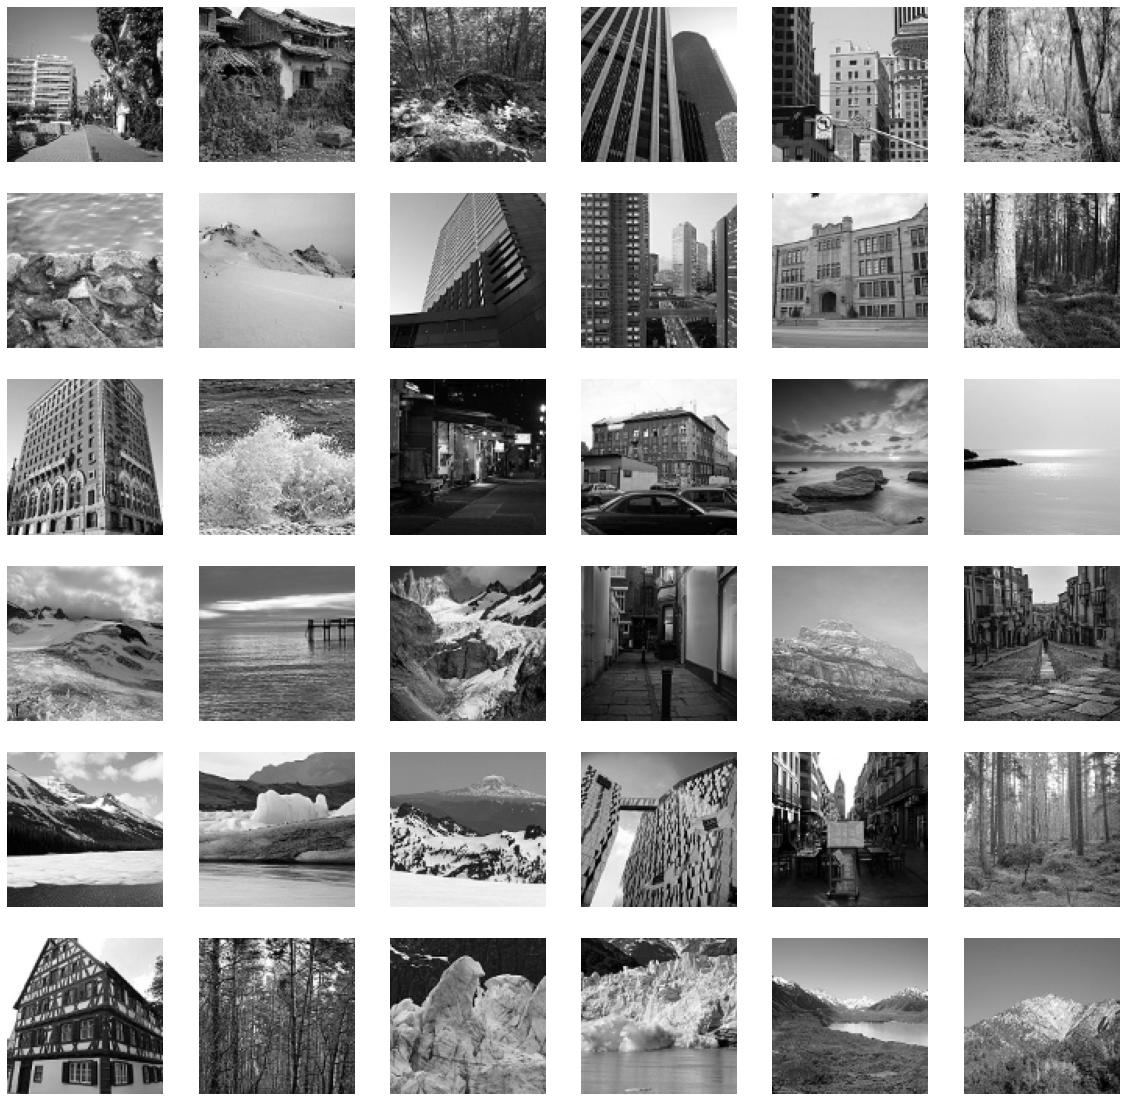

In [22]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_pred),36))) :       # print any 36 images from X_pred images.
    plt.subplot(6,6,n+1)
    plt.imshow(X_pred[i], cmap= 'gray')    
    plt.axis('off')

________

# Building The Model 

now we need to build the model to train our data

first to convert the data into arrays using numpy

In [23]:
# # must convert [x_train] & [y_train] & [X_test] & [y_test] & [X_pred_array] to numpy array before train model.
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_pred_array = np.array(X_pred)


print(f' X_train shape is:  {X_train.shape} ')
print(f' y_train shape is:  {y_train.shape} ')
print(f' X_test  shape is:  {X_test.shape} ')
print(f' y_test  shape is:  {y_test.shape} ')
print(f' X_pred  shape is:  {X_pred_array.shape} ')

 X_train shape is:  (14034, 100, 100) 
 y_train shape is:  (14034,) 
 X_test  shape is:  (3000, 100, 100) 
 y_test  shape is:  (3000,) 
 X_pred  shape is:  (7301, 100, 100) 


In [24]:
# as shown in the above cell code, the (X_train, X_test, X_pred) isn't expanded ( Channel يعني مش متضاف ليها ال) so we will add channel by ---->  np.expand_dim()

X_train= np.expand_dims(X_train, axis=-1)               # Equivalent to X_train[:,:,np.newaxis]
X_test= np.expand_dims(X_test, axis=-1)                 # Equivalent to X_test[:,:,np.newaxis]
X_pred_array= np.expand_dims(X_pred_array, axis=-1)     # Equivalent to X_pred_array[:,:,np.newaxis]


print(f' X_train shape is:  {X_train.shape} ')
print(f' X_test  shape is:  {X_test.shape} ')
print(f' X_pred  shape is:  {X_pred_array.shape} ')         # as shown the channel has been added 

 X_train shape is:  (14034, 100, 100, 1) 
 X_test  shape is:  (3000, 100, 100, 1) 
 X_pred  shape is:  (7301, 100, 100, 1) 


In [25]:
# Split the train and the validation set for the fitting
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.2, random_state= 42)


In [26]:
print(f' X_train shape is:  {X_val.shape} ')
print(f' X_train shape is:  {y_val.shape} ')

 X_train shape is:  (600, 100, 100, 1) 
 X_train shape is:  (600,) 


### now to build the CNN model by Keras , using Conv2D layers , MaxPooling & Denses

In [74]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = (s,s,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(6, activation = "softmax"))

now to compile the model , using adam optimizer , & sparse categorical crossentropy loss

In [28]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [75]:
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

so how the model looks like ? 

In [76]:
print('Model Details are : ')
print(model.summary())

Model Details are : 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      832       
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 50, 50, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 64)        36928     
                                 

In [77]:
MODEL_NUM= 1

In [78]:
early_stopping = EarlyStopping(monitor='val_loss',  patience=15, mode='min')

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience= 7, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

mc = ModelCheckpoint('/content/drive/MyDrive/CNN Examples/6Classes_model'+str(MODEL_NUM)+'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(14034, 100, 100, 1)
(14034,)
(2400, 100, 100, 1)
(2400,)
(600, 100, 100, 1)
(600,)


now to train the model , lets use 50 epochs now

In [79]:
callback= [early_stopping, learning_rate_reduction, mc]
History = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=370, verbose=1, callbacks= callback)

Epoch 1/500
38/38 [==============================] - ETA: 0s - loss: 10.2534 - accuracy: 0.2636
Epoch 1: val_loss improved from inf to 1.35301, saving model to /content/drive/MyDrive/CNN Examples/6Classes_model2.h5
38/38 [==============================] - 24s 485ms/step - loss: 10.2534 - accuracy: 0.2636 - val_loss: 1.3530 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 2/500
38/38 [==============================] - ETA: 0s - loss: 1.2753 - accuracy: 0.4866
Epoch 2: val_loss improved from 1.35301 to 1.07044, saving model to /content/drive/MyDrive/CNN Examples/6Classes_model2.h5
38/38 [==============================] - 12s 312ms/step - loss: 1.2753 - accuracy: 0.4866 - val_loss: 1.0704 - val_accuracy: 0.5783 - lr: 0.0010
Epoch 3/500
38/38 [==============================] - ETA: 0s - loss: 1.1180 - accuracy: 0.5612
Epoch 3: val_loss improved from 1.07044 to 1.00676, saving model to /content/drive/MyDrive/CNN Examples/6Classes_model2.h5
38/38 [==============================] - 12s 310ms/step - 

In [80]:
model = load_model('/content/drive/MyDrive/CNN Examples/6Classes_model'+str(MODEL_NUM)+'.h5')

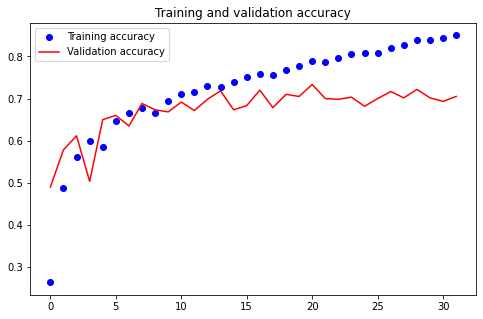

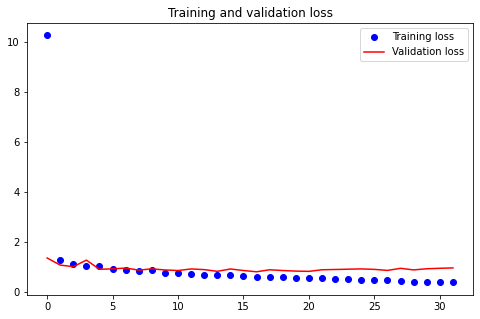

In [81]:
accuracy = History.history['accuracy']
val_accuracy = History.history['val_accuracy']
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(8, 5))
plt.plot(epochs, accuracy, 'bo')
plt.plot(epochs, val_accuracy, 'r')
plt.title('Training and validation accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.figure(figsize=(8, 5))

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'r')
plt.title('Training and validation loss')
plt.legend(['Training loss', 'Validation loss' ])
plt.show()

## Accuracy & loss of ***Training***

In [35]:
loss, acc = model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}'.format(loss))
print('Train Accuracy: {}'.format(acc))

Train loss: 0.2673488259315491
Train Accuracy: 0.9143508672714233


## Accuracy & loss of ***Validation***

In [36]:
loss, acc = model.evaluate(X_val, y_val, verbose=0)
print('Prediction loss: {}'.format(loss))
print('Prediction Accuracy: {}'.format(acc))

Prediction loss: 0.6125812530517578
Prediction Accuracy: 0.7716666460037231


## Accuracy & loss of ***Testing***

In [37]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Final_Test loss: {}'.format(loss))
print('Final_Test Accuracy: {}'.format(acc))

Final_Test loss: 0.6676536798477173
Final_Test Accuracy: 0.7745833396911621


how is the final loss & accuracy



_______

now to predict X test

In [38]:
y_pred = model.predict(X_test)

print('Prediction Shape is: ', y_pred.shape)

Prediction Shape is:  (2400, 6)


and to show random redicted pictures & its predicting category


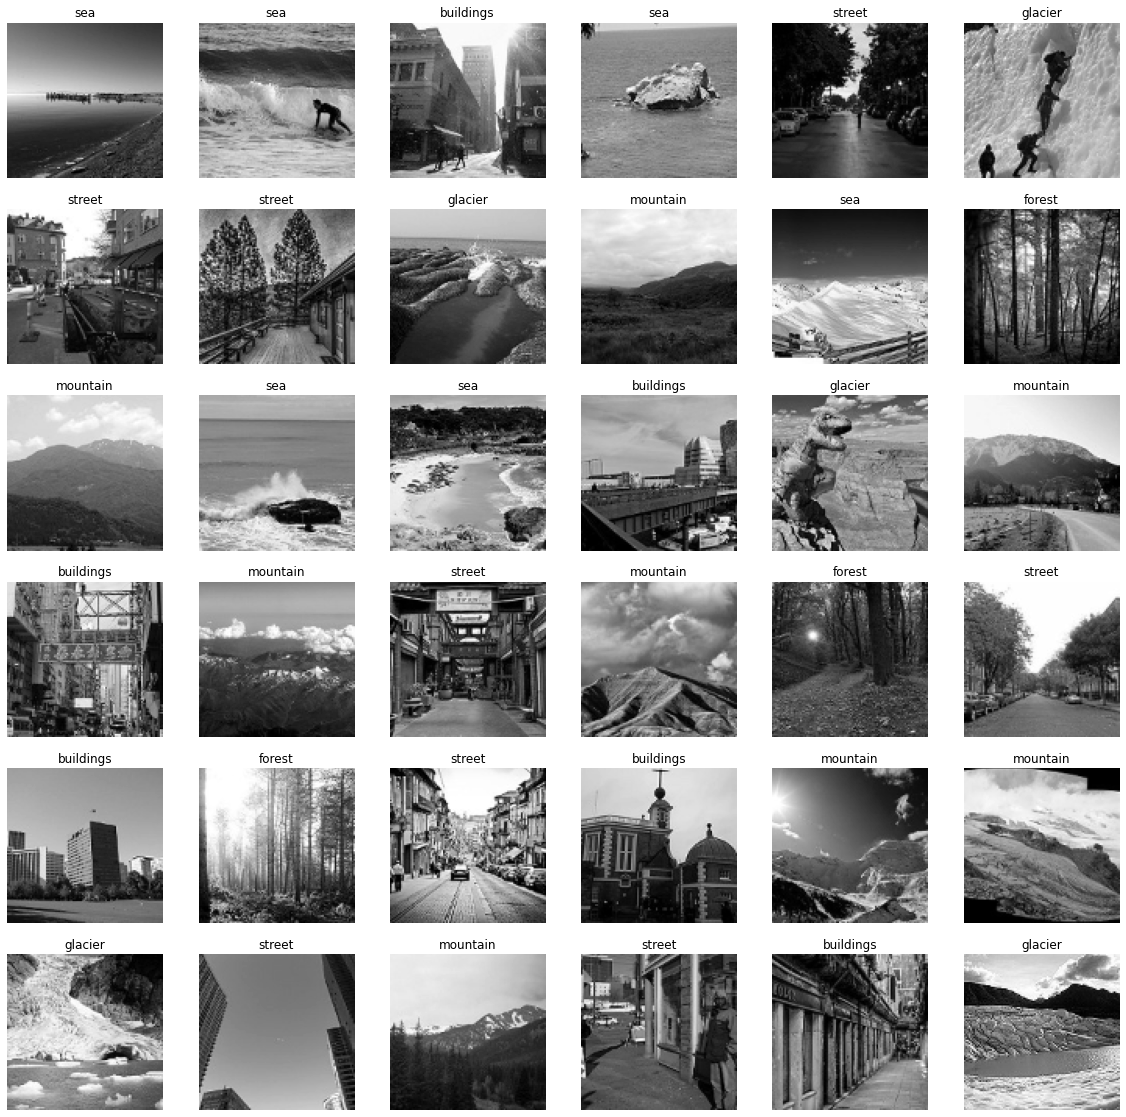

In [41]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_test),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_test[i].reshape(s, s), cmap= 'gray')    
    plt.axis('off')
    plt.title(getcode(np.argmax(y_pred[i])))

great

now it's time to redict X Predict

In [42]:
y_result = model.predict(X_pred_array)

print('Prediction Shape is: ', y_result.shape)

Prediction Shape is:  (7301, 6)


and to show random redicted pictures & its predicting category


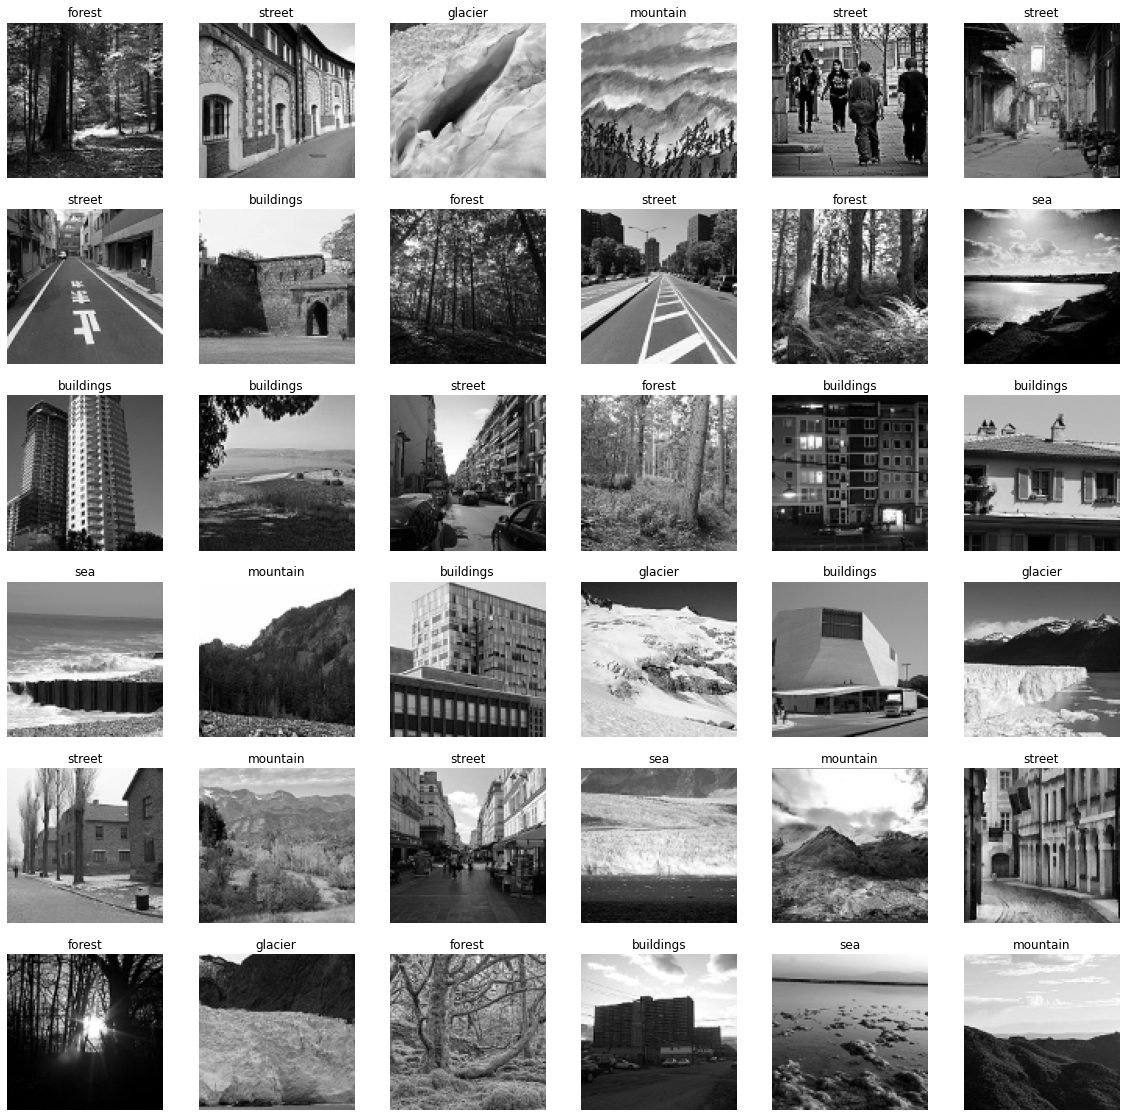

In [43]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_pred_array),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_pred_array[i].reshape(s, s), cmap= 'gray')    
    plt.axis('off')
    plt.title(getcode(np.argmax(y_result[i])))

_________________

In [45]:
labels= list(range(6))           # 6 classes
classes_name= ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

## ***Train*** Prediction

In [44]:
predict_x = model.predict(X_train) 
y_train_predict = np.argmax(predict_x, axis=1)

## Train ***Confusion Matrix***:

Text(51.0, 0.5, 'Real')

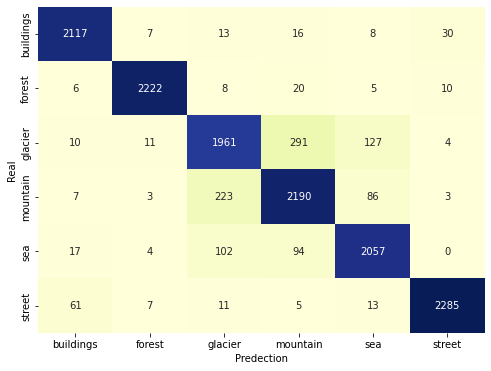

In [46]:
cmat = confusion_matrix(y_train, y_train_predict, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cmat, annot = True, cbar = False, cmap='YlGnBu', fmt="d", xticklabels=classes_name, yticklabels=classes_name);

plt.xlabel('Predection')
plt.ylabel('Real')


## ***Train*** Report

In [47]:
print(classification_report(y_train, y_train_predict))


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2191
           1       0.99      0.98      0.98      2271
           2       0.85      0.82      0.83      2404
           3       0.84      0.87      0.85      2512
           4       0.90      0.90      0.90      2274
           5       0.98      0.96      0.97      2382

    accuracy                           0.91     14034
   macro avg       0.92      0.92      0.92     14034
weighted avg       0.91      0.91      0.91     14034



_____________________________________
_____________________________________

## ***Validation*** Prediction

In [48]:
predict_x = model.predict(X_val) 
y_val_predict = np.argmax(predict_x, axis=1)

## Validation ***Confusion Matrix***:

Text(51.0, 0.5, 'Real')

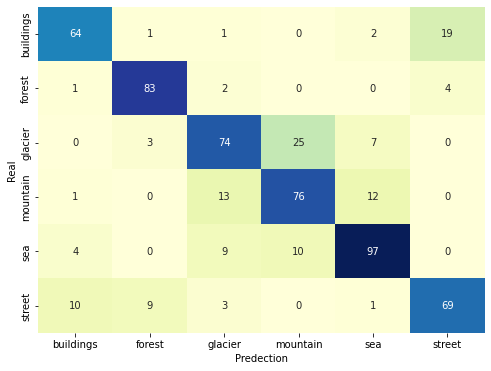

In [49]:
cmat = confusion_matrix(y_val, y_val_predict, labels= labels)
plt.figure(figsize=(8,6))
sns.heatmap(cmat, annot = True, cbar = False, cmap='YlGnBu', fmt="d", xticklabels=classes_name, yticklabels=classes_name);

plt.xlabel('Predection')
plt.ylabel('Real')


## ***Validation*** Report

In [50]:
print(classification_report(y_val, y_val_predict))


              precision    recall  f1-score   support

           0       0.80      0.74      0.77        87
           1       0.86      0.92      0.89        90
           2       0.73      0.68      0.70       109
           3       0.68      0.75      0.71       102
           4       0.82      0.81      0.81       120
           5       0.75      0.75      0.75        92

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.77       600



_____________________________________
_____________________________________

## ***Test*** Prediction

In [52]:
y_pred = model.predict(X_test)
y_test_predict= np.argmax(y_pred, axis= 1)

## Test ***Confusion Matrix***:

Text(51.0, 0.5, 'Real')

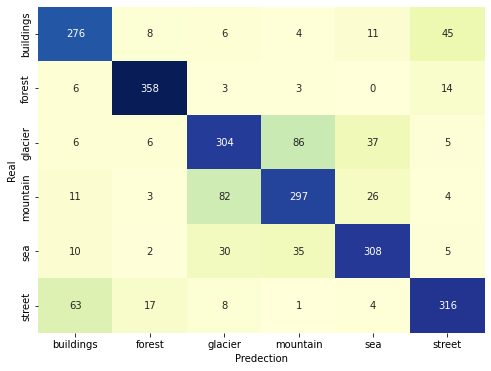

In [53]:
cmat = confusion_matrix(y_test, y_test_predict, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cmat, annot = True, cbar = False, cmap='YlGnBu', fmt="d", xticklabels=classes_name, yticklabels=classes_name);

plt.xlabel('Predection')
plt.ylabel('Real')


## ***Test*** Report

In [54]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       350
           1       0.91      0.93      0.92       384
           2       0.70      0.68      0.69       444
           3       0.70      0.70      0.70       423
           4       0.80      0.79      0.79       390
           5       0.81      0.77      0.79       409

    accuracy                           0.77      2400
   macro avg       0.78      0.78      0.78      2400
weighted avg       0.77      0.77      0.77      2400



_____
_____
_____
_____
_____
_____
_____
_____
_____
_____
_____
_____

#### We will fit the model again with data augmentation

## 3.3 Data augmentation 

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered 
The scale is not the same (some who write with big/small numbers)
The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. 

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important : 
   - Without data augmentation i obtained an accuracy of 98.114%
   - With data augmentation i achieved 99.67% of accuracy

In [55]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
          featurewise_center=False,             # set input mean to 0 over the dataset
          samplewise_center=False,              # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,   # divide each input by its std
          zca_whitening=False,                  # apply ZCA whitening
          rotation_range=10,                    # randomly rotate images in the range (degrees, 0 to 180)
          zoom_range = 0.1,                     # Randomly zoom image 
          width_shift_range=0.1,                # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,               # randomly shift images vertically (fraction of total height)
          horizontal_flip=False,                # randomly flip images
          vertical_flip=False)                  # randomly flip images


datagen.fit(X_train)

For the data augmentation, i choosed to :
   - Randomly rotate some training images by 10 degrees
   - Randomly  Zoom by 10% some training images
   - Randomly shift images horizontally by 10% of the width
   - Randomly shift images vertically by 10% of the height
   
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

In [57]:
MODEL_NUM= 1

In [58]:
early_stopping = EarlyStopping(monitor='val_loss',  patience=15, mode='min')

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience= 7, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

mc = ModelCheckpoint('/content/drive/MyDrive/CNN Examples/6Classes_model_augmentation'+str(MODEL_NUM)+'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)


In [59]:
batch_size = 86
callback= [early_stopping, learning_rate_reduction, mc]

In [60]:
# Fit the model
History = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = 500, validation_data = (X_val, y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks= callback)

Epoch 1/500
163/163 [==============================] - ETA: 0s - loss: 0.9807 - accuracy: 0.6320
Epoch 1: val_loss improved from inf to 0.72333, saving model to /content/drive/MyDrive/CNN Examples/6Classes_model_augmentation1.h5
163/163 [==============================] - 20s 102ms/step - loss: 0.9807 - accuracy: 0.6320 - val_loss: 0.7233 - val_accuracy: 0.7483 - lr: 0.0010
Epoch 2/500
163/163 [==============================] - ETA: 0s - loss: 0.8299 - accuracy: 0.6976
Epoch 2: val_loss did not improve from 0.72333
163/163 [==============================] - 16s 98ms/step - loss: 0.8299 - accuracy: 0.6976 - val_loss: 0.7445 - val_accuracy: 0.7233 - lr: 0.0010
Epoch 3/500
163/163 [==============================] - ETA: 0s - loss: 0.7743 - accuracy: 0.7195
Epoch 3: val_loss did not improve from 0.72333
163/163 [==============================] - 17s 101ms/step - loss: 0.7743 - accuracy: 0.7195 - val_loss: 1.0122 - val_accuracy: 0.6533 - lr: 0.0010
Epoch 4/500
163/163 [======================

In [61]:
model = load_model('/content/drive/MyDrive/CNN Examples/6Classes_model_augmentation'+str(MODEL_NUM)+'.h5')

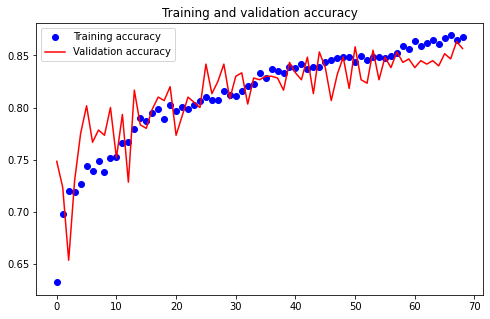

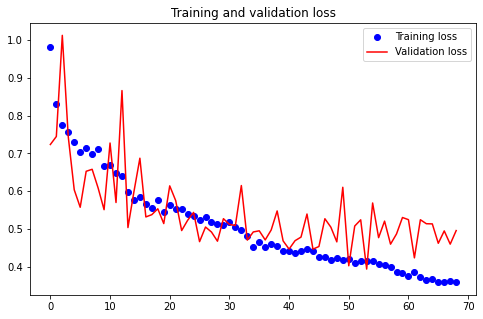

In [62]:
accuracy = History.history['accuracy']
val_accuracy = History.history['val_accuracy']
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(8, 5))
plt.plot(epochs, accuracy, 'bo')
plt.plot(epochs, val_accuracy, 'r')
plt.title('Training and validation accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.figure(figsize=(8, 5))

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'r')
plt.title('Training and validation loss')
plt.legend(['Training loss', 'Validation loss' ])
plt.show()

## Accuracy & loss of ***Training***

In [63]:
loss, acc = model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}'.format(loss))
print('Train Accuracy: {}'.format(acc))

Train loss: 0.3277471363544464
Train Accuracy: 0.8780105710029602


## Accuracy & loss of ***Validation***

In [64]:
loss, acc = model.evaluate(X_val, y_val, verbose=0)
print('Prediction loss: {}'.format(loss))
print('Prediction Accuracy: {}'.format(acc))

Prediction loss: 0.39355653524398804
Prediction Accuracy: 0.8550000190734863


## Accuracy & loss of ***Testing***

In [65]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Final_Test loss: {}'.format(loss))
print('Final_Test Accuracy: {}'.format(acc))

Final_Test loss: 0.5043501853942871
Final_Test Accuracy: 0.8445833325386047


great

now it's time to redict X Predict

In [68]:
y_result = model.predict(X_pred_array)

print('Prediction Shape is: ', y_result.shape)

Prediction Shape is:  (7301, 6)


and to show random redicted pictures & its predicting category


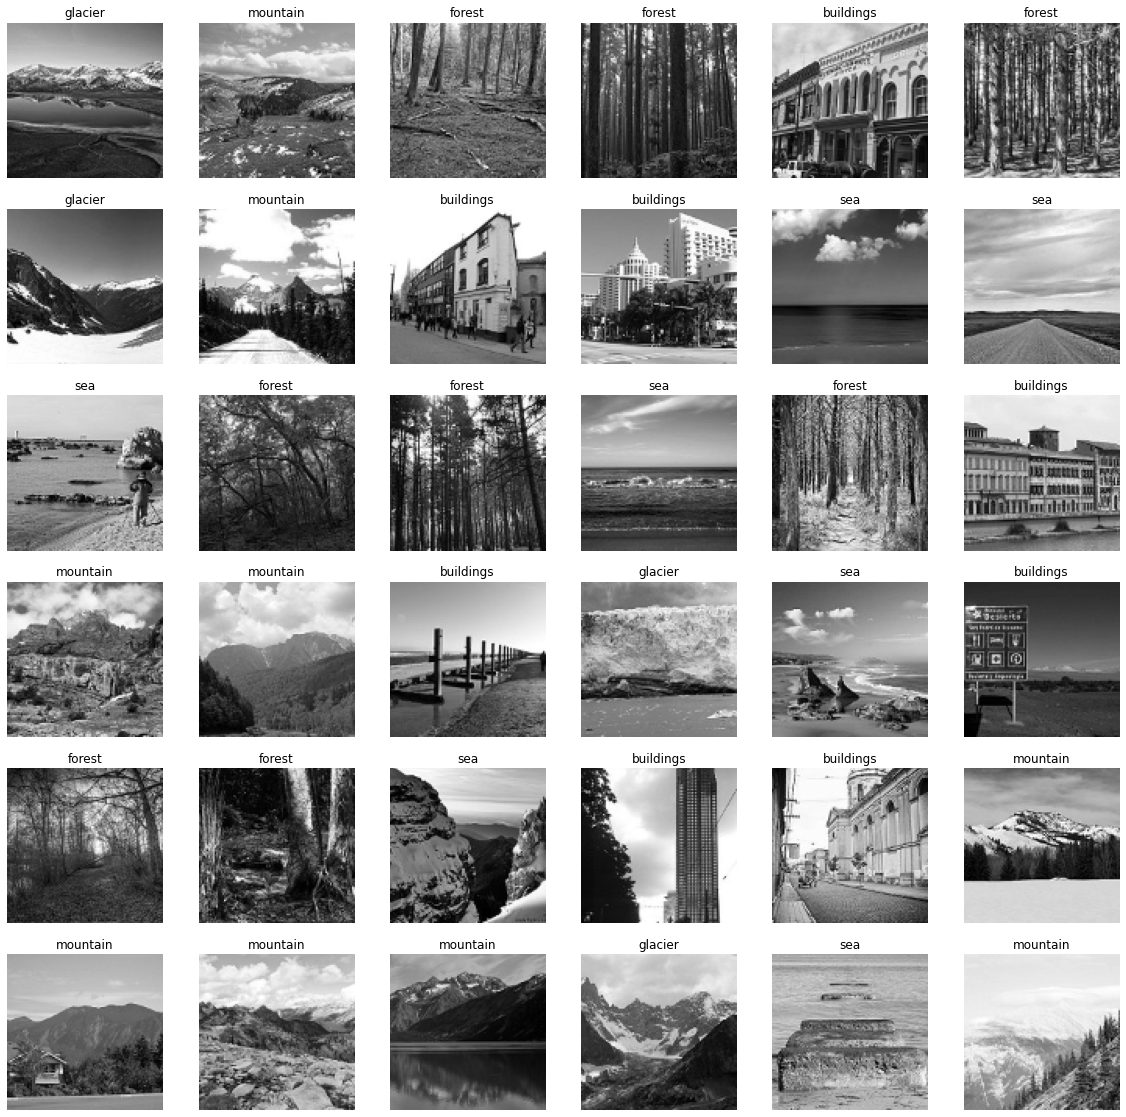

In [69]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_pred_array),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_pred_array[i].reshape(s, s), cmap= 'gray')    
    plt.axis('off')
    plt.title(getcode(np.argmax(y_result[i])))

## ***Test*** Prediction

In [70]:
y_pred = model.predict(X_test)
y_test_predict= np.argmax(y_pred, axis= 1)

## Test ***Confusion Matrix***:

Text(51.0, 0.5, 'Real')

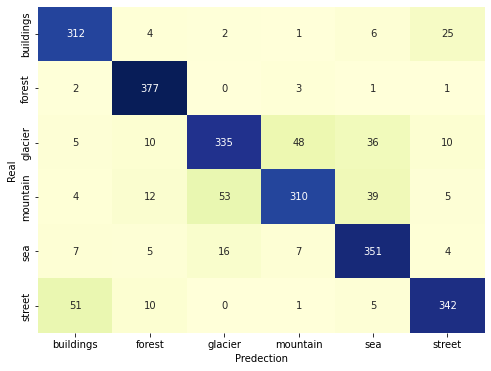

In [71]:
cmat = confusion_matrix(y_test, y_test_predict, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cmat, annot = True, cbar = False, cmap='YlGnBu', fmt="d", xticklabels=classes_name, yticklabels=classes_name);

plt.xlabel('Predection')
plt.ylabel('Real')


## ***Test*** Report

In [72]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       350
           1       0.90      0.98      0.94       384
           2       0.83      0.75      0.79       444
           3       0.84      0.73      0.78       423
           4       0.80      0.90      0.85       390
           5       0.88      0.84      0.86       409

    accuracy                           0.84      2400
   macro avg       0.84      0.85      0.85      2400
weighted avg       0.84      0.84      0.84      2400

